In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import time
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
import datetime
from twilio.rest import Client
from fuzzywuzzy import fuzz
from datetime import timedelta
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler
from sklearn.preprocessing import  StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# Functions

In [2]:
def get_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred).round(3)
    precision = precision_score(y_test, y_pred).round(3)
    recall = recall_score(y_test, y_pred).round(3)
    f1 = f1_score(y_test, y_pred).round(3)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)

def transform_poly(df_transform):
    poly = PolynomialFeatures(2)
    df_poly = pd.DataFrame(poly.fit_transform(df_transform))
    df_poly.columns = poly.get_feature_names(df_transform.columns)
    df_transform = df_poly.copy()
    return df_transform

 # Step 1: Understanding and Contextualising the Problem
 The first step in a Machine Learning process is to clearly understand the problem and work out how it can be solved in a well-defined and measurable way. We need to determine whether it's a regression, classification, clustering, or other type of problem. <br><br>
The objective is to build a model that is able to predict the winners for the fixtures on the 25th of February, 2023. At first glance, this seems like a classification problem, as we want to attribute a probalitic chance to each team winning their particular match.

# Step 2: Collect and preprocess the data, carry out EDA



In [3]:
df_box = pd.read_csv('box_scores.csv')
df_fixt = pd.read_csv('fixture_information.csv')
df_fixt_test = pd.read_csv('test_fixtures.csv')
df_fixt_actual = pd.read_csv('test_fixtures_actuals.csv')

In [4]:
df_box.shape,df_fixt.shape,df_fixt_test.shape,df_fixt_actual.shape

((13322, 15), (6661, 8), (130, 7), (260, 18))

In [5]:
df_box['PTS'] = df_box['2PM']*2+df_box['3PM']*3+df_box['FTM']

In [6]:
df_train = pd.merge(df_box,df_fixt)


In [7]:
df_test_25_feb = pd.merge(df_fixt_actual,df_fixt_test)


In [8]:
# I am going to add the train and test dataset together so it is easier to format and feature engineer
# I will then split them up before modelling starts

In [9]:
df_train['data_type'] = 'train'

In [10]:
df_test_25_feb['data_type'] = 'test'

In [11]:
df_all = pd.concat([df_train,df_test_25_feb],ignore_index=True)
df_all = df_all.drop(['Attendance','TeamHandicap','IsWinner'],axis=1)

In [12]:
# currently each team has no defensive stats, by reformating we can easily add def stats

df_all['Home'] = df_all['FixtureKey'].apply(lambda x: x.split(' v ')[0])
df_all['Away'] = df_all['FixtureKey'].apply(lambda x: x.split(' v ')[1].rsplit(' ',1)[0])
df_all['Date'] = df_all['FixtureKey'].apply(lambda x: pd.to_datetime(x.rsplit(' ',1)[1]))
df_all['Team_name'] = df_all.apply(lambda x: x['Home'] if x['Team']==1 else x['Away'],axis=1)

df_all_def = df_all.copy()
df_all_def['Team'] = df_all_def['Team'].apply(lambda x: 2 if x==1 else 1)
df_all_def = df_all_def[['FixtureKey', 'Team', '2PM', '2PA', '3PM', '3PA', 'FTM', 'FTA', 'ORB',
       'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF','PTS']]
for col in df_all_def.columns[2:]:
    df_all_def = df_all_def.rename(columns={col:col+'_def'})

df_all = pd.merge(df_all,df_all_def)

In [13]:
# As the goal in basketball is to generate as big a point difference as possible, I thought it made 
# more sense to have the att/def dif, rather than two variables for att/def
for col in ['2PM', '2PA', '3PM', '3PA', 'FTM', 'FTA', 'ORB',
       'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF','PTS']:
    df_all[col+'_dif'] = df_all[col]-df_all[col+'_def']

df_all = df_all.drop(['2PM', '2PA', '3PM', '3PA', 'FTM', 'FTA', 'ORB',
       'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF','PTS','2PM_def',
       '2PA_def', '3PM_def', '3PA_def', 'FTM_def', 'FTA_def', 'ORB_def',
       'DRB_def', 'AST_def', 'STL_def', 'BLK_def', 'TOV_def', 'PF_def','PTS_def'],axis=1)

In [14]:
df_all.head(2)
# each row currently shows ingame data which we would not have if we are betting.
# therefore we need to reformat, so each match shows past data for the upcoming match.

,FixtureKey,GameType,IsNeutralSite,Season,Team,Team1Conference,Team2Conference,TipOff,data_type,Home,Away,Date,Team_name,2PM_dif,2PA_dif,3PM_dif,3PA_dif,FTM_dif,FTA_dif,ORB_dif,DRB_dif,AST_dif,STL_dif,BLK_dif,TOV_dif,PF_dif,PTS_dif
0,LIPSCO v A PEAY 14-Jan-2023,RegularSeason,0,2023,2,A-Sun,A-Sun,17:00,train,LIPSCO,A PEAY,2023-01-14,A PEAY,2,12,-3,-1,-9,-13,5,-6,-4,2,2,-1,3,-14
1,LIPSCO v A PEAY 14-Jan-2023,RegularSeason,0,2023,1,A-Sun,A-Sun,17:00,train,LIPSCO,A PEAY,2023-01-14,LIPSCO,-2,-12,3,1,9,13,-5,6,4,-2,-2,1,-3,14


In [15]:
def get_past_data(team_name,date,games_back):
    prev_team_games = df_all.loc[(df_all['Team_name']==team_name) & (df_all['Date']<date)].sort_values('Date')
    prev_team_games = prev_team_games.tail(games_back)[[
          '2PM_dif', '2PA_dif', '3PM_dif', '3PA_dif',
       'FTM_dif', 'FTA_dif', 'ORB_dif', 'DRB_dif', 'AST_dif', 'STL_dif',
       'BLK_dif', 'TOV_dif', 'PF_dif','PTS_dif']]
    for col in prev_team_games.columns:
        prev_team_games = prev_team_games.rename(columns={col:col+'_'+str(games_back)})
    prev_team_games = prev_team_games.mean().to_frame().T
    return prev_team_games.loc[0].to_list()

In [16]:
df_all_past_list = []

for x in df_all.index:
    if x%1000==0: print(x,datetime.now())
    df_all_past_list.append(get_past_data(df_all['Team_name'][x],df_all['Date'][x],20))

0 2025-11-14 11:56:21.976006
1000 2025-11-14 11:56:32.578548
2000 2025-11-14 11:56:43.241659
3000 2025-11-14 11:56:53.605736
4000 2025-11-14 11:57:03.724052
5000 2025-11-14 11:57:13.813235
6000 2025-11-14 11:57:24.105859
7000 2025-11-14 11:57:34.983569
8000 2025-11-14 11:57:45.562698
9000 2025-11-14 11:57:56.005478
10000 2025-11-14 11:58:06.511543
11000 2025-11-14 11:58:17.136662
12000 2025-11-14 11:58:29.894047
13000 2025-11-14 11:58:48.160605


In [17]:
df_all_past = pd.DataFrame(df_all_past_list,columns=['2PM_dif_10', '2PA_dif_10', '3PM_dif_10', '3PA_dif_10',
       'FTM_dif_10', 'FTA_dif_10', 'ORB_dif_10', 'DRB_dif_10', 'AST_dif_10', 'STL_dif_10',
       'BLK_dif_10', 'TOV_dif_10', 'PF_dif_10','PTS_dif_10'])


In [18]:
df_all = pd.concat([df_all, df_all_past], axis=1)
# now each row includes the teams averages over the last 5 games
# the earliest matches in the dataset obviously will not have past_matches so I have removed them

In [19]:
df_all = df_all.dropna()

In [20]:
df_all['Won'] = (df_all['PTS_dif']>0)*1

In [21]:
rem_cols = ['2PM_dif', '2PA_dif', '3PM_dif', '3PA_dif',
       'FTM_dif', 'FTA_dif', 'ORB_dif', 'DRB_dif', 'AST_dif', 'STL_dif',
       'BLK_dif', 'TOV_dif', 'PF_dif','PTS_dif']
df_all = df_all.drop(rem_cols,axis=1)
#  remove columns that we wouldn't know before the start of the match

In [22]:
df_all_opp = df_all.copy()
df_all_opp['Team'] = df_all_opp['Team'].apply(lambda x: 2 if x==1 else 1)
df_all_opp = df_all_opp[['FixtureKey', 'Team', '2PM_dif_10', '2PA_dif_10', '3PM_dif_10',
       '3PA_dif_10', 'FTM_dif_10', 'FTA_dif_10', 'ORB_dif_10', 'DRB_dif_10',
       'AST_dif_10', 'STL_dif_10', 'BLK_dif_10', 'TOV_dif_10', 'PF_dif_10',
       'PTS_dif_10']]
for col in df_all_opp.columns[2:]:
    df_all_opp = df_all_opp.rename(columns={col:col+'_opp'})

In [23]:
df_all = pd.merge(df_all,df_all_opp)

### Encoding Categorical Variables
Certain features will be in text form rather than numerical form, therefore we need to reformat those variables.


In [24]:
rem_cols = ['TipOff', 'GameType', 'data_type', 'Home', 'Away', 'Team_name']
df_all = df_all.drop(rem_cols,axis=1)

In [25]:
df_all = pd.get_dummies(df_all, columns=['Team1Conference','Team2Conference'])

In [26]:
df_test_1 = df_all.loc[df_all['Date']>='2023-02-25']
df_train = df_all.loc[df_all['Date']<'2023-02-25']

In [27]:
df_test_25_feb_final = pd.merge(df_test_1,df_test_25_feb[['FixtureKey','Team','IsWinner']])

In [28]:
df_test_25_feb_final = df_test_25_feb_final.loc[df_test_25_feb_final['Team']==1]
df_train = df_train.loc[df_train['Team']==1]

In [29]:
df_test_25_feb_final = df_test_25_feb_final.drop(['FixtureKey','Date','Team'],axis=1)
df_train = df_train.drop(['FixtureKey','Date','Team'],axis=1)

In [30]:
# as each game takes up two rows, and each row has all the features of both home/away I am deleting
# one of the duplicates

 ### Exploratory Data Analysis (EDA)
EDA is the process of trying to gain a better understanding of the data, by identifying missing values, outliers, and understanding the relationships between variables. 
There are a few steps we can take here:
- Graphs: We can use scatter, boxplots, histograms to visually understand the data better
- Grouping of data: This helps us see how data is grouped in a table format
- Correlation Matrix: Correlation is a statistical metric for measuring to what extent different variables are interdependent.

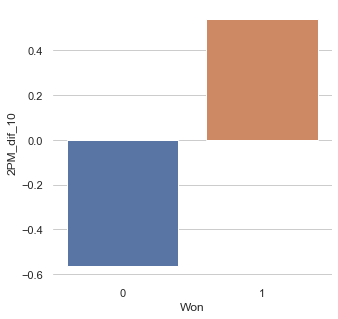

In [31]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(5, 5))
sns.despine(f, left=True, bottom=True)

sns.barplot(
    data=df_train,
    x="Won",
    y="2PM_dif_10",
    ci=None
)

# Step 3: Split the Data
Now we need to split the dataset into training, validation, and testing sets. The training set is used for model training, the validation set for hyperparameter tuning, and the testing set for evaluating the final model. The typical split is 70-80% for training, 10-15% for validation, and 10-15% for testing.

In [75]:
df_test_final = df_test_25_feb_final.copy()
X_final = df_test_final[features]
y_final = df_test_final[[target_variable]]

target_variable = 'Won'
features = df_train.drop([target_variable],axis=1).columns

X = df_train[features]
y = df_train[[target_variable]]


In [76]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [77]:
print('X shapes:',X_train.shape, X_test.shape)
print('y shapes:',y_train.shape, y_test.shape)

X shapes: (5135, 94) (1284, 94)
y shapes: (5135, 1) (1284, 1)


# Step 4: Feature engineering
Next we need to carry out feature selection to identify the relevant features. This can be done by reviewing the EDA, knowledge of the topic or testing for feature importance. 
After that we will then carry out feature transformation, such as applying polynomial features, normalisaiton and/or generating new features from our existing features.

### Add Polynomial Features
Polynomial Fetaures can be useful when the relationship between the features and the target variable is nonlinear. 
By adding Polynomial Fetaures, we can capture more complex patterns and improve the model's ability to fit the data.

In [78]:
X_train = transform_poly(X_train)
X_test = transform_poly(X_test)
X_final = transform_poly(X_final)
print('X shapes:',X_train.shape, X_test.shape)
print('y shapes:',y_train.shape, y_test.shape)
print('test_25_feb shape',X_final.shape)

X shapes: (5135, 4560) (1284, 4560)
y shapes: (5135, 1) (1284, 1)
test_25_feb shape (130, 4560)


### Scale data/Normalisation
Normalization is the process of scaling down data. Below I have used MinMaxScaler which scales the data between 0 and 1. This makes the training process less sensitive to the scale of the features. This can result in getting better coefficients after training.

In [79]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_final = scaler.transform(X_final)

# Step 5: Model Selection and Model Training
In this step, We will go through different models trying to find the model the produces the best results. Once we have selected a model we can then fine tune it. 

### Logistic Regression

In [37]:
lr_class = LogisticRegression()
lr_class.fit(X_train, y_train)
y_pred = lr_class.predict(X_test)
get_scores(y_test, y_pred)

Accuracy:  0.609
Precision:  0.697
Recall:  0.671
F1 Score:  0.684


### KNeighbors Classifier

In [38]:
knn_class = KNeighborsClassifier(n_neighbors=2)
knn_class.fit(X_train, y_train)
y_pred = knn_class.predict(X_test)
get_scores(y_test, y_pred)

Accuracy:  0.589
Precision:  0.763
Recall:  0.504
F1 Score:  0.607


### DecisionTree Classifier

In [39]:
dt_class = DecisionTreeClassifier()
dt_class.fit(X_train, y_train)
y_pred = dt_class.predict(X_test)
get_scores(y_test, y_pred)

Accuracy:  0.61
Precision:  0.698
Recall:  0.67
F1 Score:  0.684


### RandomForest Classifier

In [40]:
rf_class = RandomForestClassifier()
rf_class.fit(X_train, y_train)
y_pred = rf_class.predict(X_test)
get_scores(y_test, y_pred)

Accuracy:  0.633
Precision:  0.71
Recall:  0.706
F1 Score:  0.708


### Naive Bayes Classifier

In [41]:
nb_class = GaussianNB()
nb_class.fit(X_train, y_train)
y_pred = nb_class.predict(X_test)
get_scores(y_test, y_pred)


Accuracy:  0.451
Precision:  0.81
Recall:  0.168
F1 Score:  0.278


### Neural Network

In [42]:
def build_nn(neurons=64, dropout=0.2, lr=0.001):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout))
    model.add(Dense(neurons//2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [43]:
nn_model = KerasClassifier(build_fn=build_nn, verbose=0)
history = nn_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    verbose=0)
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int)
get_scores(y_test, y_pred_nn)

Accuracy:  0.656
Precision:  0.717
Recall:  0.749
F1 Score:  0.733


# Step 6: Hyperparameter Tuning
The next step involves optimising the model's hyperparameters to improve its performance.<br><br>
Logistic Regression is one of the better performing baseline models, so we can now run that through GridSearchCV

In [49]:
# Choose the best performaing model
gs_cv_class = lr_class

param_grid = {
    'penalty': ['l2','l1'],
#     'C': [0.1, 1.0, 10.0],
#     'solver': ['liblinear', 'lbfgs'],
#     'max_iter': [100],
#     'class_weight': [None]
}

grid_search = GridSearchCV(estimator=gs_cv_class, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
final_model_class = grid_search.best_estimator_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'penalty': 'l1'}
Best Score:  0.6266796494644596


In [50]:
y_pred = final_model_class.predict(X_test)
get_scores(y_test, y_pred)

Accuracy:  0.616
Precision:  0.699
Recall:  0.685
F1 Score:  0.692


In [47]:

param_grid = {
    'neurons': [32, 64, 128],
    'dropout': [0.1, 0.2, 0.3],
    'lr': [0.001, 0.0005],
    'epochs': [15, 30],
    'batch_size': [16, 32],
}

grid_search = GridSearchCV(
    estimator=nn_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
final_model_nn = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'batch_size': 16, 'dropout': 0.3, 'epochs': 15, 'lr': 0.0005, 'neurons': 32}
Best Score: 0.6407010710808179


In [80]:
y_pred = final_model_nn.predict(X_final)
get_scores(y_final, y_pred)

Accuracy:  0.7
Precision:  0.741
Recall:  0.769
F1 Score:  0.755


# Step 7: Use Algorithm to predict 25th Feb results

In [87]:
y_pred_final = final_model_nn.predict(X_final)
y_prob_final = final_model_nn.predict_proba(X_final)
get_scores(y_final, y_pred_final)

Accuracy:  0.7
Precision:  0.741
Recall:  0.769
F1 Score:  0.755


In [108]:
df_test_final['pred'] = [x[0] for x in y_pred_final]
df_test_final['prob'] = [x[1] for x in y_prob_final]

# Final Results

Out of the 130 (260 rows of home/away) matches the model predicted 70% of them correctly.

In [109]:
correct_preds = (df_test_final['pred']==df_test_final['IsWinner']).mean()
print(f'Number of games predicted correctly on final dataset: {correct_preds}')

Number of games predicted correctly on final dataset: 0.7
